In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.models import Model, load_model
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add

# Read Captions File

In [4]:
# Reading the Description file

with open("./Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [5]:
captions = captions.split("\n")[:-1]

In [6]:
len(captions)

40460

In [7]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for ele in captions:
    i_to_c = ele.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    # if key is not present, initialise it with empty list.
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []

    descriptions[img_name].append(cap)

In [8]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [9]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 2 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [10]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

In [11]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

In [12]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [13]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [15]:
# creating the unique vocabulary 

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [16]:
#  ALL words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('All Words Size: %d' % len(all_vocab))
print(all_vocab[:15])

All Words Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [17]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [18]:
len(all_vocab)

1845

# Loading Training Testing Data

In [19]:
# TrainImagesFile
f = open("Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [20]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [21]:
# TestImagesFile
f = open("Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [22]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [23]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

# Data Preprocessing - Images

In [25]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [26]:
#model.summary()

In [27]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [28]:
images = "./Flicker8k_Dataset/"

In [29]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = img.reshape(1,224,224,3)
    img = preprocess_input(img)
    return img

In [30]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [31]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    #"C:\Users\91702\test\Flickr8k_Dataset\Flicker8k_Dataset\2513260012_03d33305cf.jpg"
    img = "./Flicker8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 1s 1s/step
Encoding image- 0
1/1 [==============================] - 0s 125ms/step


KeyboardInterrupt: 

In [ ]:
# Save the bottleneck train encoding to disk

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [32]:
# TEST IMAGES

start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "./Flicker8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 134ms/step
Encoding image- 0
1/1 [==============================] - 0s 121ms/step


KeyboardInterrupt: 

In [32]:
# Save the bottleneck test ecoding to disk

with open("./storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [33]:
# Load the train images encoding from disk

with open("./storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [32]:
# Load the test images encoding from disk

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [33]:
encoding_test['3385593926_d3e9c21170.jpg'].shape

(2048,)

In [36]:
encoding_test

{'3385593926_d3e9c21170.jpg': array([0.33316973, 0.38347808, 0.07253451, ..., 0.90831906, 0.3560046 ,
        1.0914074 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.294561  , 0.09500475, 0.7013538 , ..., 0.01996786, 0.29111952,
        0.10959288], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.01133571, 0.08780418, 0.14325379, ..., 0.03005864, 1.1857153 ,
        0.06954585], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770495, 1.4354485 , 0.10770191, ..., 0.13344474, 0.11505543,
        2.0496256 ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552849, 6.682829  , 0.31763467, ..., 0.0620041 , 0.03742895,
        0.04522466], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562058 , 0.04316777, 0.11143785, ..., 0.02008329, 0.6832557 ,
        0.43294084], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876401, 1.1927906 , 0.07676459, ..., 0.01899927, 0.13417585,
        0.13799421], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

In [37]:
encoding_train['2513260012_03d33305cf.jpg'].shape

(2048,)

# Data Preprocessing - Captions

In [33]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [34]:
#  need to add these 2 words as well (explicitly)
 
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [35]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [36]:
# Max length kitni ho sakti hai? Caption ki
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


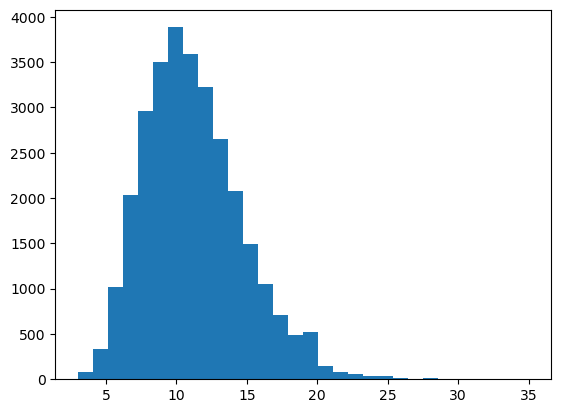

In [37]:
a=plt.hist(all_captions_len, bins=30)

In [38]:
with open("./storage/word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("./storage/idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

# Data Preparation using Generator Function

In [39]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

In [45]:
my_gen = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)

NameError: name 'number_pics_per_batch' is not defined

In [ ]:
X, y = next(my_gen)

In [ ]:
X[0].shape

In [ ]:
X[1].shape

In [ ]:
y.shape

# Word Embedding

In [40]:
f = open("./GloVE/glove.6B.50d.txt", encoding='utf8')

In [41]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

## Converting words into vectors  Directly - (Embedding Layer Output)

In [42]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [43]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [44]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [45]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [46]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 50)               92400     ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [48]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [51]:
!pip install pydot


In [53]:
!pip install graphviz

In [54]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Our Model

In [56]:
epochs = 60
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [57]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

C:\Users\91702\AppData\Local\Temp\ipykernel_21020\2804007631.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


 283/2000 [===>..........................] - ETA: 23s - loss: 5.2397

KeyboardInterrupt: 

In [61]:
model = load_model("./model_weights/model_40.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

# Predictions

In [63]:
def predict_caption(photo):
    """
    photo => encoding of that image (2048,)
    """
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

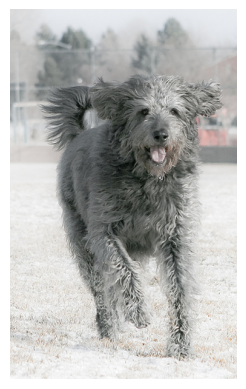

1/1 [==============================] - 0s 37ms/step
dog is running through water


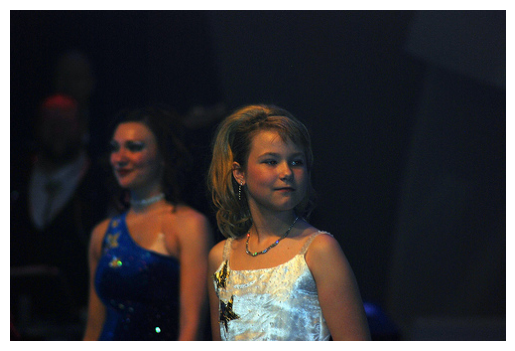

1/1 [==============================] - 0s 31ms/step
man in black shirt and black shirt is standing in stadium


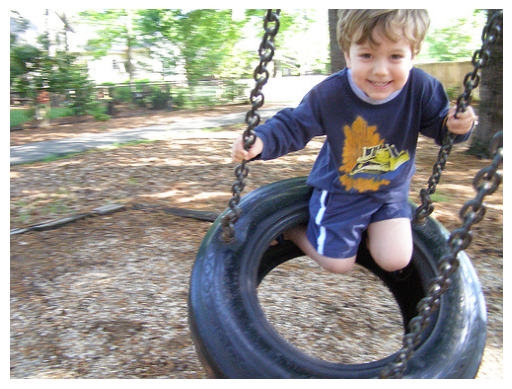

1/1 [==============================] - 0s 16ms/step
little girl in red shirt and blue sweater is swinging on swing


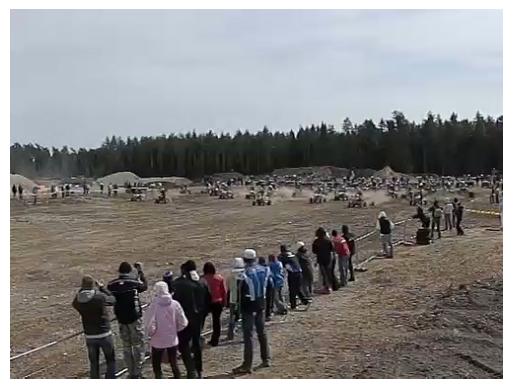

1/1 [==============================] - 0s 24ms/step
people are riding bikes on the day


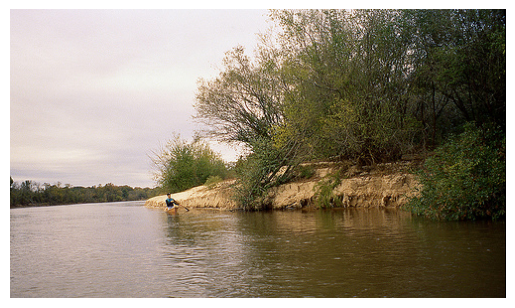

1/1 [==============================] - 0s 28ms/step
the person is diving canoe in lake


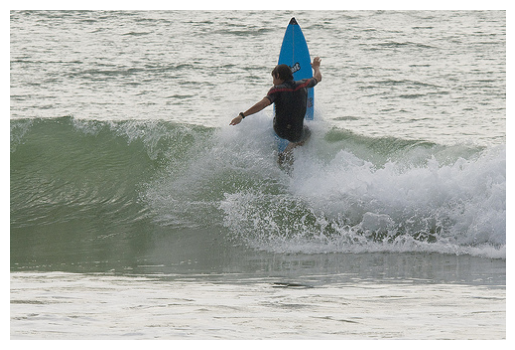

1/1 [==============================] - 0s 16ms/step
man in wetsuit is surfing


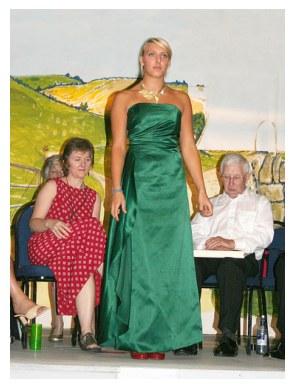

1/1 [==============================] - 0s 31ms/step
two girls are playing with teenage boys


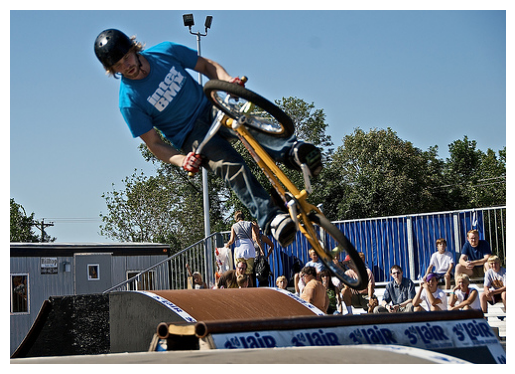

1/1 [==============================] - 0s 35ms/step
man in black jacket and blue cap is snowboarding on concrete surface


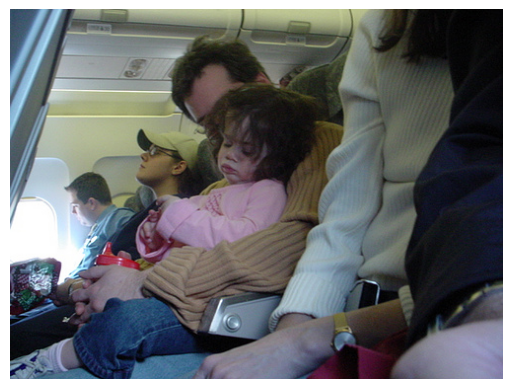

1/1 [==============================] - 0s 35ms/step
man in blue shirt and glasses reads book to push on the floor of car


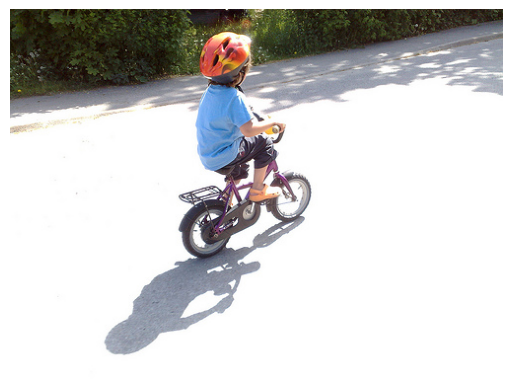

1/1 [==============================] - 0s 16ms/step
man on motorcycle is riding on dirt track


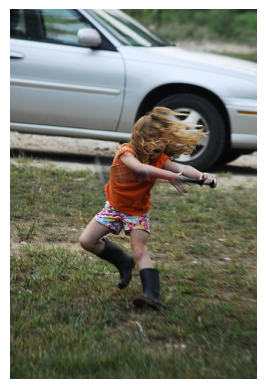

1/1 [==============================] - 0s 32ms/step
little girl in red dress and blue boots is swinging


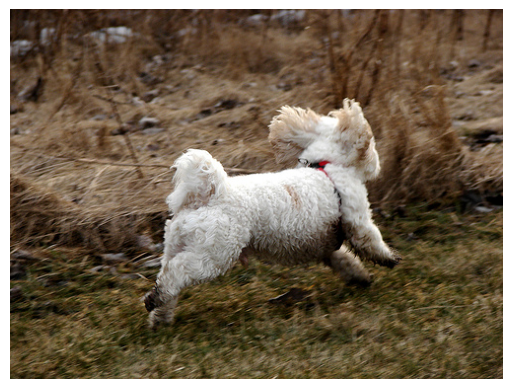

1/1 [==============================] - 0s 31ms/step
white dog is running on the beach


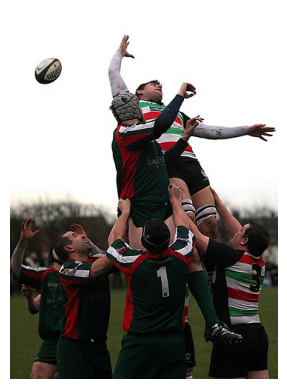

1/1 [==============================] - 0s 32ms/step
two men are playing soccer


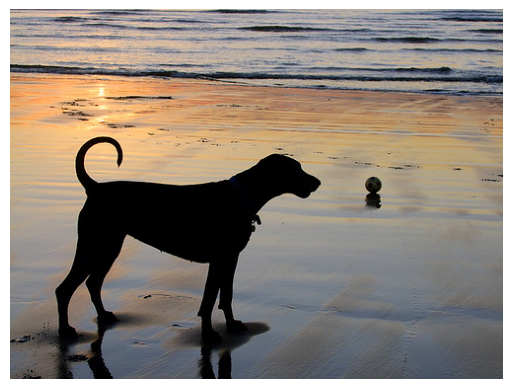

1/1 [==============================] - 0s 33ms/step
black and white dog is running on the beach


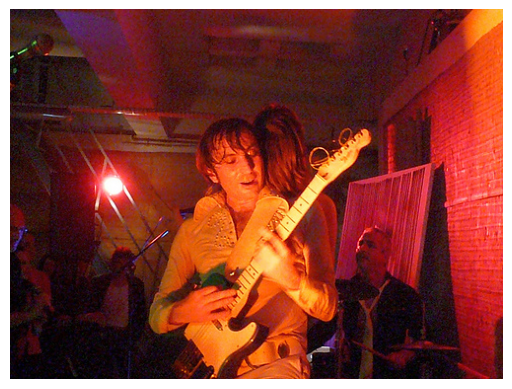

1/1 [==============================] - 0s 35ms/step
man in white shirt and black shirt is standing in hand


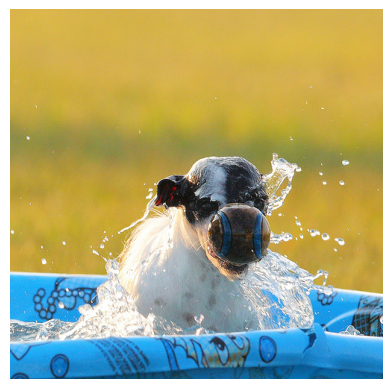

1/1 [==============================] - 0s 22ms/step
dog swims in pool


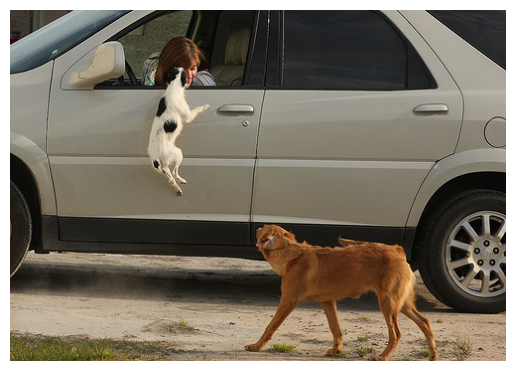

1/1 [==============================] - 0s 29ms/step
dog is jumping over hurdle


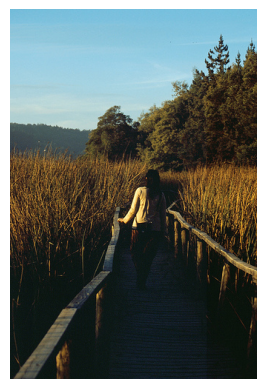

1/1 [==============================] - 0s 27ms/step
two people are walking along the beach at sunset


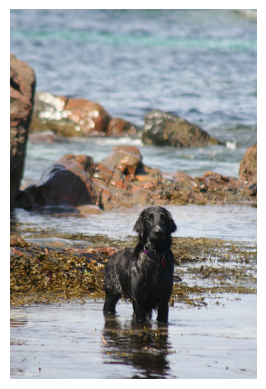

1/1 [==============================] - 0s 25ms/step
dog swims through the water


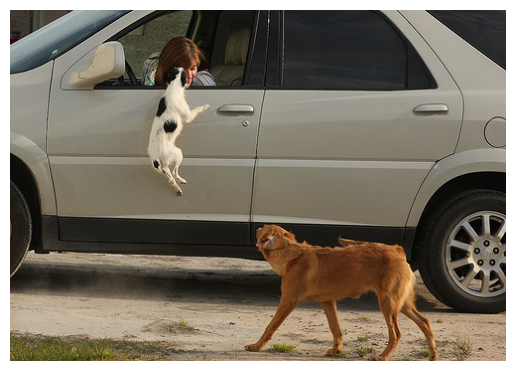

1/1 [==============================] - 0s 16ms/step
dog is jumping over hurdle
1/1 [==============================] - 0s 29ms/step


In [ ]:
for i in range(10):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+'/'+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    #evaluate_model(descriptions,photo)
    print(caption)
evaluate_model(descriptions,photo)

## Metric

In [70]:
def evaluate_model(descriptions,photo):
    actual,predicted  = list() , list()

    for key ,desc_list in descriptions.items():
        ypred = predict_caption(photo)
        refrences = [d.split() for d in desc_list]
        actual.append(refrences)
        predicted.append(ypred.split())
    

    # Calculate BLEU score
    print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))